<a href="https://colab.research.google.com/github/CodeHriday/colab/blob/main/major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Eye For Blind**

**Problem Statement:**
Create a model which is able to caption an image to help blind people, so that they can also get the feel of image.

**Notebook Description:**
This notebook will contain code which are used to create audio text from an given image which very useful for blind people.

Attention model mechenism has been used with Encoder and Decorder mechenism.
**Greedy Search** and **Beam Search** has been used

**Encoder:** It will get create the features of the image</br>
**Decoder:** It use the features created by Encoder and output from attention model.</br>
**Attention Mechenism:** It is used to overcome the problem of Encoder and Decoder architecture. By using this we need to focus only the specific part of the image while generating caption (as human do i.e when we want to describe any paerticular object we only focus on that object as that time).

In [4]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:05<00:00, 211MB/s]
100% 1.04G/1.04G [00:05<00:00, 196MB/s]


In [5]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [6]:
import gc
gc.collect()

151

In [7]:
# import libraries

import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split 

#model building 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tqdm import tqdm

# Libraries to convert text into audio
#from gtts import gTTS
#from IPython import display

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
ls

captions.txt  gdrive/  Images/  sample_data/


In [9]:
# Defining paths
INPUT_PATH = "../content/"
IMAGE_PATH = INPUT_PATH+'Images/'
CAPTIONS_FILE = INPUT_PATH+'captions.txt'
OUTPUT_IMAGE_PATH = "../content/"

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path

In [10]:
all_imgs = glob.glob(IMAGE_PATH + '*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


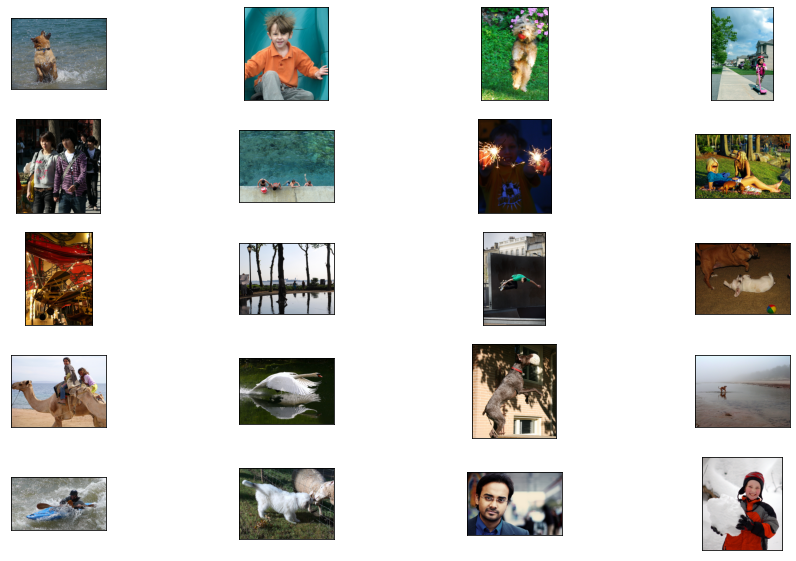

In [11]:
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols 
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(0,num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mpimg.imread(all_imgs[i]))

In [12]:
# reading the caption file
def doc_name(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [13]:
text = doc_name(CAPTIONS_FILE)
print(text[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [14]:
all_img_id = []
all_img_vector = []
annotations = []
# get image_id, image_caption and image_path
def getImgIdCapPath(text):
    text = text.splitlines()[1:]
    for line in text:
        com_id =line.index(",")
        img_id = line[:com_id]
        all_img_id.append(img_id)
        annotations.append(line[com_id +1:])
        all_img_vector.append(IMAGE_PATH + "/" + img_id)
        

In [15]:
getImgIdCapPath(text)
df= pd.DataFrame(zip(all_img_id, all_img_vector, annotations), columns=['Id', 'Path', 'Captions'])
df.head()

,Id,Path,Captions
0,1000268201_693b08cb0e.jpg,../content/Images//1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,../content/Images//1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,../content/Images//1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,../content/Images//1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,../content/Images//1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [17]:
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

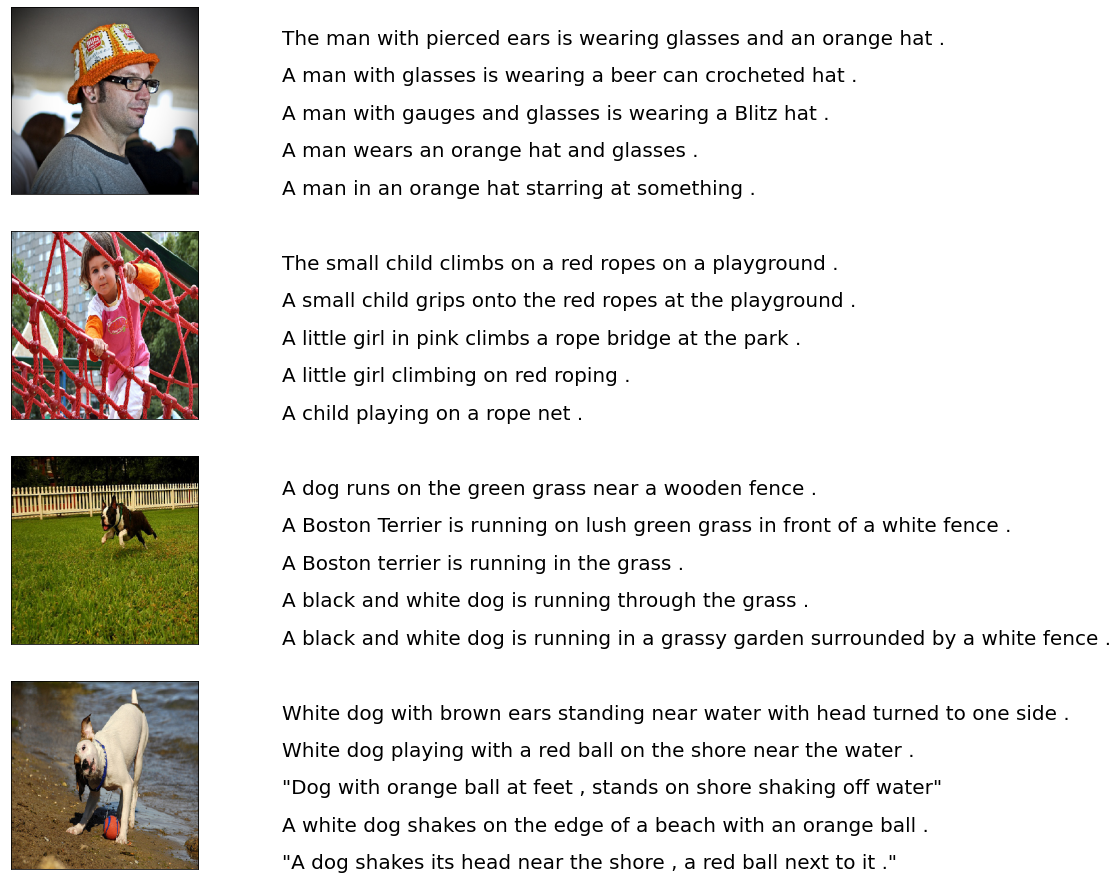

In [18]:
# Images 
fig = plt.figure(figsize=(10,20))
count = 1
    
for Path in df[20:40].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

In [19]:
annotations=[]
for cap in df.Captions:
    cap='<start> '+ cap + ' <end>'
    annotations.append(cap)
annotations[:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>']

In [20]:
uni_filenames= np.unique(df.Id.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:", Counter(Counter(df.Id.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


In [21]:
# get the vocabulary from the captions
vocab = []
def get_vocabulary():
    for cap in df.Captions.values:
        vocab.extend(cap.split())
    print("Size of vocabulary", len(set(vocab)))
    return vocab

In [22]:
vocabulary = get_vocabulary()
value_count = Counter(vocabulary)

Size of vocabulary 9862


In [23]:
sorted_list = value_count.most_common(30)
stop_word = set(stopwords.words('english'))

def plotWordCount(wordCountList):
    word_list,wc_list = [],[]
    for word, count in wordCountList:
        word_list.append(word)
        wc_list.append(count)
    plt.figure(figsize=(20,6))
    sns.barplot(x = word_list, y = wc_list, orient='v').set_title('Top 30 occurinng words')
        

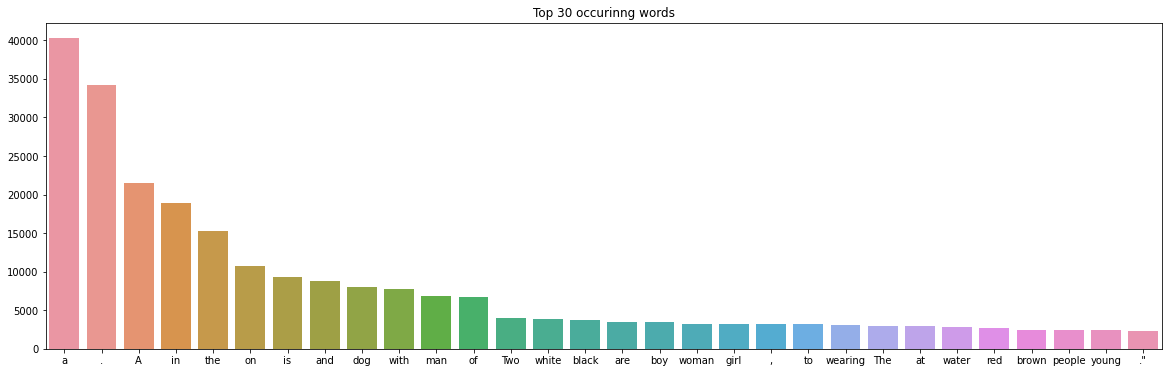

In [24]:
plotWordCount(sorted_list)

**Initialize InceptionV3 and load the pretrained Imagenet weights**

Now we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

we forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
After all the images are passed through the network, you save the dictionary to disk.

In [25]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 0s 0us/step


In [26]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [27]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


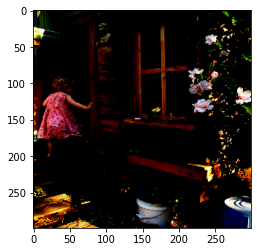

In [28]:
print("Shape after resize :", load_image(all_img_vector[0])[0].shape)
plt.imshow(load_image(all_img_vector[0])[0])

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [29]:
#Get unique images
encode_train = sorted(set(all_img_vector))

feature_dict = {}

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [30]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32,)


In [31]:
print("Unique number of Images:", len(encode_train))

Unique number of Images: 8091


In [32]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  bf.numpy()

100%|██████████| 253/253 [01:21<00:00,  3.09it/s]


In [33]:
import gc
gc.collect()
len(feature_dict)

8091

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [34]:
# create the tokenizer
top_word_cnt = 5000
special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,
                                                  oov_token="<unk>",
                                                  filters=special_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [35]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [36]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [37]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

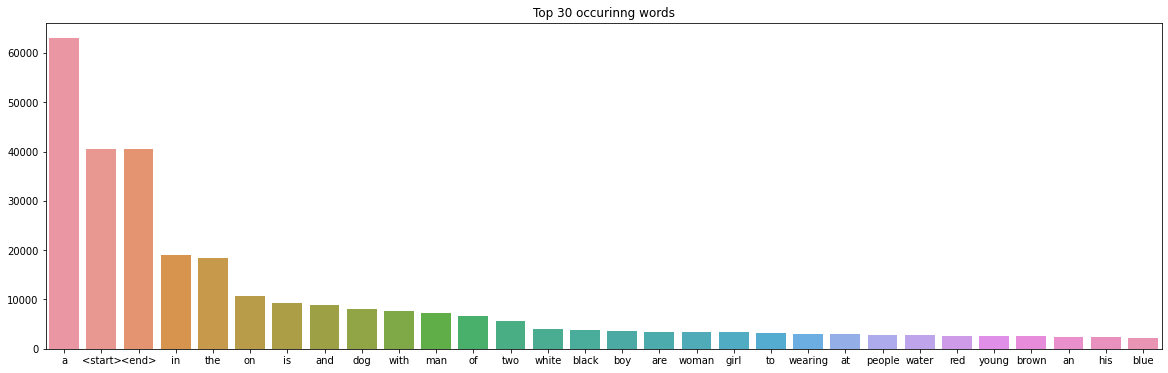

In [38]:
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plotWordCount(sort_word_by_count[:30])

In [39]:
def calc_max_length(tensor):
    max_t=max([len(t) for t in tensor])
    print("The maximum length of a sentence in the annotation dataset is: " + str(max_t))
    return max_t

In [40]:
max_length = calc_max_length(train_seqs)
cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The maximum length of a sentence in the annotation dataset is: 39
The shape of Caption vector is :(40455, 39)


In [41]:
img_train, img_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [42]:
print("Training data for images: " + str(len(img_train)))
print("Testing data for images: " + str(len(img_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<start> a muzzled white dog is running on the grass <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


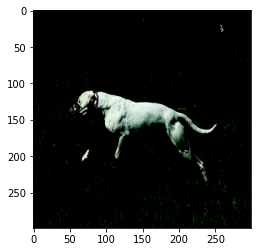

In [43]:
# checking the image caption relationship
print(" ".join(tokenizer.index_word[i] for i in cap_test[3]))
plt.imshow(load_image(img_test[3])[0])

In [44]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

In [45]:
def generate_dataset(images_data, captions_data, BATCH_SIZE =32, BUFFER_SIZE = 1000):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [46]:
train_dataset=generate_dataset(img_train,cap_train)
test_dataset=generate_dataset(img_test,cap_test)

In [47]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [48]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train) // BATCH_SIZE
test_num_steps = len(img_test) // BATCH_SIZE
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

## Encoder

In [49]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.nn.relu(features)
        
        return features

In [50]:
encoder=Encoder(embedding_dim)

## Attention Model

In [51]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

## Decoder

In [52]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask = mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [53]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [54]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)


Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [55]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [56]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [57]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [58]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [59]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [60]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [61]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [62]:
loss_plot = []
test_loss_plot = []

In [63]:
def training_Model():
    EPOCHS = 20

    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / train_num_steps)

        if epoch % 5 == 0:
          ckpt_manager.save()

        print(f'Epoch {epoch+1} Loss {total_loss/train_num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [64]:
training_Model()

Epoch 1 Batch 0 Loss 2.4802
Epoch 1 Batch 100 Loss 1.5879
Epoch 1 Batch 200 Loss 1.4224
Epoch 1 Batch 300 Loss 1.1252
Epoch 1 Batch 400 Loss 1.1857
Epoch 1 Batch 500 Loss 1.1349
Epoch 1 Batch 600 Loss 1.1896
Epoch 1 Batch 700 Loss 1.0773
Epoch 1 Batch 800 Loss 1.0088
Epoch 1 Batch 900 Loss 1.1923
Epoch 1 Batch 1000 Loss 1.1504
Epoch 1 Loss 1.198496
Time taken for 1 epoch 172.81 sec

Epoch 2 Batch 0 Loss 0.8715
Epoch 2 Batch 100 Loss 0.8517
Epoch 2 Batch 200 Loss 1.0515
Epoch 2 Batch 300 Loss 0.9490
Epoch 2 Batch 400 Loss 1.0439
Epoch 2 Batch 500 Loss 0.9392
Epoch 2 Batch 600 Loss 0.8583
Epoch 2 Batch 700 Loss 0.9425
Epoch 2 Batch 800 Loss 0.8920
Epoch 2 Batch 900 Loss 0.9090
Epoch 2 Batch 1000 Loss 0.9635
Epoch 2 Loss 0.955840
Time taken for 1 epoch 104.82 sec

Epoch 3 Batch 0 Loss 0.9496
Epoch 3 Batch 100 Loss 0.8302
Epoch 3 Batch 200 Loss 0.9041
Epoch 3 Batch 300 Loss 0.8192
Epoch 3 Batch 400 Loss 0.8852
Epoch 3 Batch 500 Loss 0.7331
Epoch 3 Batch 600 Loss 0.8604
Epoch 3 Batch 700 Lo

In [65]:
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.334, & test loss is 1.026
Time taken for 1 epoch 178.44675040245056 sec

Test loss has been reduced from 100.000 to 1.026


 13%|█▎        | 2/15 [05:08<35:33, 164.11s/it]

For epoch: 2, the train loss is 0.342, & test loss is 0.888
Time taken for 1 epoch 129.87237000465393 sec

Test loss has been reduced from 1.026 to 0.888


 20%|██        | 3/15 [07:18<30:47, 153.93s/it]

For epoch: 3, the train loss is 0.335, & test loss is 0.800
Time taken for 1 epoch 129.96638107299805 sec

Test loss has been reduced from 0.888 to 0.800


 27%|██▋       | 4/15 [09:29<26:55, 146.85s/it]

For epoch: 4, the train loss is 0.330, & test loss is 0.737
Time taken for 1 epoch 130.14326167106628 sec

Test loss has been reduced from 0.800 to 0.737
For epoch: 5, the train loss is 0.322, & test loss is 0.687
Time taken for 1 epoch 130.4110505580902 sec

Test loss has been reduced from 0.737 to 0.687


 40%|████      | 6/15 [13:49<20:44, 138.24s/it]

For epoch: 6, the train loss is 0.314, & test loss is 0.646
Time taken for 1 epoch 129.3467721939087 sec

Test loss has been reduced from 0.687 to 0.646


 47%|████▋     | 7/15 [15:58<18:03, 135.43s/it]

For epoch: 7, the train loss is 0.309, & test loss is 0.614
Time taken for 1 epoch 128.67044043540955 sec

Test loss has been reduced from 0.646 to 0.614


 53%|█████▎    | 8/15 [18:06<15:33, 133.40s/it]

For epoch: 8, the train loss is 0.302, & test loss is 0.584
Time taken for 1 epoch 128.5005612373352 sec

Test loss has been reduced from 0.614 to 0.584


 60%|██████    | 9/15 [20:15<13:12, 132.05s/it]

For epoch: 9, the train loss is 0.296, & test loss is 0.556
Time taken for 1 epoch 128.73338174819946 sec

Test loss has been reduced from 0.584 to 0.556


 67%|██████▋   | 10/15 [22:24<10:55, 131.13s/it]

For epoch: 10, the train loss is 0.289, & test loss is 0.532
Time taken for 1 epoch 128.82583236694336 sec

Test loss has been reduced from 0.556 to 0.532


 73%|███████▎  | 11/15 [24:33<08:41, 130.46s/it]

For epoch: 11, the train loss is 0.285, & test loss is 0.511
Time taken for 1 epoch 128.7099802494049 sec

Test loss has been reduced from 0.532 to 0.511


 80%|████████  | 12/15 [26:42<06:30, 130.03s/it]

For epoch: 12, the train loss is 0.279, & test loss is 0.494
Time taken for 1 epoch 128.87182641029358 sec

Test loss has been reduced from 0.511 to 0.494


 87%|████████▋ | 13/15 [28:51<04:19, 129.77s/it]

For epoch: 13, the train loss is 0.276, & test loss is 0.472
Time taken for 1 epoch 129.0008111000061 sec

Test loss has been reduced from 0.494 to 0.472


 93%|█████████▎| 14/15 [31:02<02:10, 130.02s/it]

For epoch: 14, the train loss is 0.272, & test loss is 0.457
Time taken for 1 epoch 130.41367435455322 sec

Test loss has been reduced from 0.472 to 0.457
For epoch: 15, the train loss is 0.266, & test loss is 0.442
Time taken for 1 epoch 130.61827182769775 sec

Test loss has been reduced from 0.457 to 0.442


100%|██████████| 15/15 [33:13<00:00, 132.89s/it]


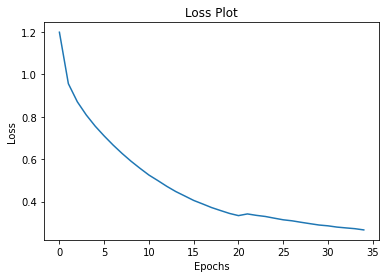

In [66]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function usininit_stateeam search ( optional)

3.Test it on a sample data using BLEU score

## Greedy Search

In [67]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    print("dec_input Shape", dec_input.shape)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #print("Predicted id", predicted_id)
        #print("result", tokenizer.index_word[predicted_id])

        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

## Beam Search

In [68]:
# Using Beam Search Evaluation
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [69]:
# Plotting different parts of the image which are used for captioning
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [70]:
# Removing start unk and end tag from the caption
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [71]:
def Testing_Model(img_test):
    #Testing on test image
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    # test_image = './images/413231421_43833a11f5.jpg'
    # real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption      :', real_caption)
    print ('Prediction Caption:', pred_caption)
    print ('')
    plot_attmap(result, attention_plot, test_image)
    plt.imshow(load_image(test_image)[0])
    return test_image, pred_caption

dec_input Shape (1, 1)
Real Caption      : a driver is sitting in a team penske race car
Prediction Caption: a driver racing in a snow covered <unk> as red car marked team penske on track tire of blue and black racing car in an <unk> car at the start of the driver



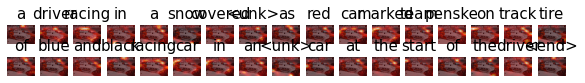

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


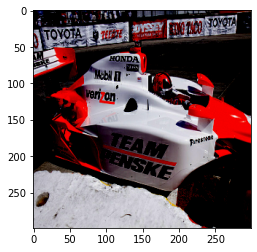

In [72]:
test_image, pred_caption = Testing_Model(img_test)

In [73]:
beam_caption=beam_evaluate(test_image)
print(beam_caption)

a driver


# Converting Text into Audio

In [75]:
#Caption to audio conversion
from gtts import gTTS
from IPython import display
soundFile = 'pred_caption.mp3'

tts = gTTS(pred_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))



ModuleNotFoundError: ignored

In [ ]:
#Caption to audio conversion using beam Evaluation
soundFile = 'beam_caption.mp3'

tts = gTTS(beam_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))